In [1]:
import numpy as np
from astropy.io import fits
import os
import glob

def normalize_fits_image(input_path, output_path, method='minmax', percentile_clip=None):
    """
    Normalize a FITS image to 0-1 range.
    
    Parameters:
    -----------
    input_path : str
        Path to input FITS file
    output_path : str
        Path to output normalized FITS file
    method : str
        'minmax' - normalize using min/max values
        'percentile' - normalize using percentile clipping (robust to outliers)
    percentile_clip : tuple
        (low, high) percentiles for clipping, e.g., (0.5, 99.5)
        Only used if method='percentile'
    """
    
    print(f"Processing: {os.path.basename(input_path)}")
    
    # Read FITS file
    with fits.open(input_path) as hdul:
        data = hdul[0].data.astype(np.float64)
        header = hdul[0].header
        
        # Store original statistics
        orig_min = np.nanmin(data)
        orig_max = np.nanmax(data)
        orig_mean = np.nanmean(data)
        orig_std = np.nanstd(data)
        
        print(f"  Original stats:")
        print(f"    Min: {orig_min:.6f}, Max: {orig_max:.6f}")
        print(f"    Mean: {orig_mean:.6f}, Std: {orig_std:.6f}")
        
        # Normalize based on method
        if method == 'minmax':
            # Simple min-max normalization
            norm_data = (data - orig_min) / (orig_max - orig_min)
            
        elif method == 'percentile':
            if percentile_clip is None:
                percentile_clip = (0.5, 99.5)
            
            # Calculate percentile values
            low_val = np.nanpercentile(data, percentile_clip[0])
            high_val = np.nanpercentile(data, percentile_clip[1])
            
            print(f"  Percentile clipping: {percentile_clip[0]}% = {low_val:.6f}, {percentile_clip[1]}% = {high_val:.6f}")
            
            # Clip and normalize
            norm_data = np.clip(data, low_val, high_val)
            norm_data = (norm_data - low_val) / (high_val - low_val)
        
        else:
            raise ValueError("method must be 'minmax' or 'percentile'")
        
        # Ensure no NaN or Inf values
        norm_data = np.nan_to_num(norm_data, nan=0.0, posinf=1.0, neginf=0.0)
        
        # Final statistics
        norm_min = np.min(norm_data)
        norm_max = np.max(norm_data)
        norm_mean = np.mean(norm_data)
        
        print(f"  Normalized stats:")
        print(f"    Min: {norm_min:.6f}, Max: {norm_max:.6f}, Mean: {norm_mean:.6f}")
        
        # Update header with normalization info
        header['NORMALIZED'] = (True, 'Image normalized to 0-1 range')
        header['NORM_METH'] = (method, 'Normalization method')
        header['ORIG_MIN'] = (float(orig_min), 'Original minimum value')
        header['ORIG_MAX'] = (float(orig_max), 'Original maximum value')
        header['ORIG_MEAN'] = (float(orig_mean), 'Original mean value')
        header['ORIG_STD'] = (float(orig_std), 'Original std deviation')
        
        if method == 'percentile':
            header['PCTL_LOW'] = (percentile_clip[0], 'Low percentile for clipping')
            header['PCTL_HIGH'] = (percentile_clip[1], 'High percentile for clipping')
        
        # Save normalized image
        hdu = fits.PrimaryHDU(data=norm_data.astype(np.float32), header=header)
        hdu.writeto(output_path, overwrite=True)
        print(f"  Saved to: {output_path}\n")


def batch_normalize_filters(input_dir, output_dir=None, method='minmax', percentile_clip=None):
    """
    Normalize all FITS files in a directory.
    
    Parameters:
    -----------
    input_dir : str
        Directory containing stacked FITS files
    output_dir : str
        Output directory for normalized files (default: input_dir/normalized)
    method : str
        Normalization method ('minmax' or 'percentile')
    percentile_clip : tuple
        Percentile values for clipping if method='percentile'
    """
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.join(input_dir, 'normalized')
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Find all FITS files
    fits_files = glob.glob(os.path.join(input_dir, '*.fits')) + \
                 glob.glob(os.path.join(input_dir, '*.fit')) + \
                 glob.glob(os.path.join(input_dir, '*.FIT')) + \
                 glob.glob(os.path.join(input_dir, '*.FITS'))
    
    if not fits_files:
        print(f"No FITS files found in {input_dir}")
        return
    
    print(f"Found {len(fits_files)} FITS file(s)")
    print(f"Output directory: {output_dir}\n")
    print("="*60)
    
    # Process each file
    for fits_file in sorted(fits_files):
        base_name = os.path.basename(fits_file)
        output_path = os.path.join(output_dir, f"normalized_{base_name}")
        
        normalize_fits_image(fits_file, output_path, method, percentile_clip)
    
    print("="*60)
    print("Normalization complete!")
    print(f"Normalized images saved in: {output_dir}")


# Main execution
if __name__ == "__main__":
    
    # Define paths
    input_directory = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED"
    
    # Choose normalization method:
    # 'minmax' - uses actual min/max (sensitive to outliers/hot pixels)
    # 'percentile' - uses percentile clipping (robust, recommended for astrophotography)
    
    # Option 1: Simple min-max normalization
    print("METHOD 1: Min-Max Normalization")
    print("="*60)
    batch_normalize_filters(input_directory, method='minmax')
    
    # Option 2: Percentile-based normalization (RECOMMENDED)
    # This is more robust against hot pixels and outliers
    # Uncomment the lines below to use this method instead:
    
    # print("\nMETHOD 2: Percentile-based Normalization (Robust)")
    # print("="*60)
    # output_dir_percentile = os.path.join(input_directory, 'normalized_percentile')
    # batch_normalize_filters(input_directory, 
    #                         output_dir=output_dir_percentile,
    #                         method='percentile', 
    #                         percentile_clip=(0.5, 99.5))
    
    print("\nNext steps:")
    print("1. Examine the normalized images")
    print("2. Proceed with stretching (log, hyperbolic, asinh)")
    print("3. You may want to apply background subtraction before stretching if needed")

METHOD 1: Min-Max Normalization
Found 4 FITS file(s)
Output directory: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized

Processing: NGC1365_clear_stacked_sigma3.0.fits
  Original stats:
    Min: -997.167938, Max: 67193.342672
    Mean: 347.091082, Std: 315.598657
  Normalized stats:
    Min: 0.000000, Max: 1.000000, Mean: 0.019713
  Saved to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized/normalized_NGC1365_clear_stacked_sigma3.0.fits

Processing: NGC1365_g_stacked_sigma3.0.fits
  Original stats:
    Min: -1279.372551, Max: 66455.920942
    Mean: 29.036858, Std: 153.819835


  Normalized stats:
    Min: 0.000000, Max: 1.000000, Mean: 0.019317
  Saved to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized/normalized_NGC1365_g_stacked_sigma3.0.fits

Processing: NGC1365_i_stacked_sigma3.0.fits
  Original stats:
    Min: -1249.601012, Max: 68836.192466
    Mean: 80.803701, Std: 119.260066
  Normalized stats:
    Min: 0.000000, Max: 1.000000, Mean: 0.018983
  Saved to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized/normalized_NGC1365_i_stacked_sigma3.0.fits

Processing: NGC1365_r_stacked_sigma3.0.fits
  Original stats:
    Min: -817.736126, Max: 68190.675052
    Mean: 54.618072, Std: 194.728651
  Normalized stats:
    Min: 0.000000, Max: 1.000000, Mean: 0.012641
  Saved to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized/normalized_NGC1365_r_stacked_sigma3.0.fits

Creating comparison visualizations for 4 images...
Using asinh stretch for display

Processing: NGC1365_clear_stacked_sigma3.0.fits
Saved comparison to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons/comparison_NGC1365_clear_stacked_sigma3.0.png


/tmp/ipykernel_8267/1671702020.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


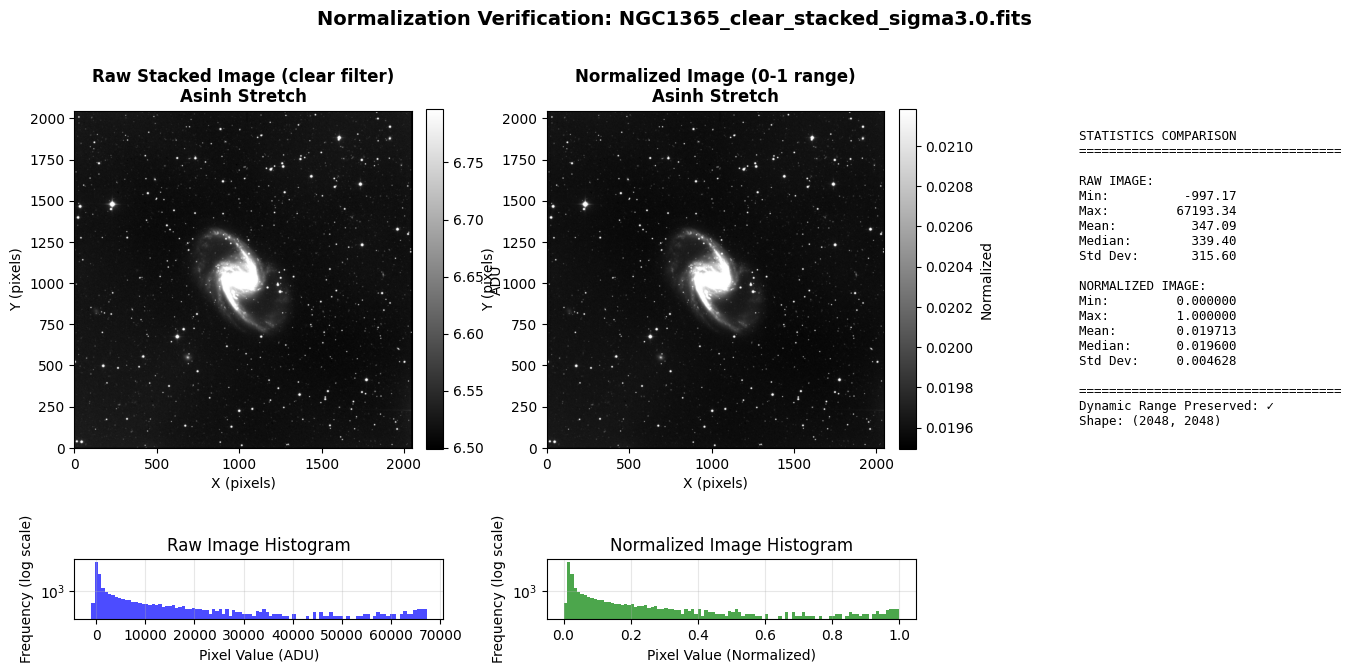


Processing: NGC1365_g_stacked_sigma3.0.fits
Saved comparison to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons/comparison_NGC1365_g_stacked_sigma3.0.png


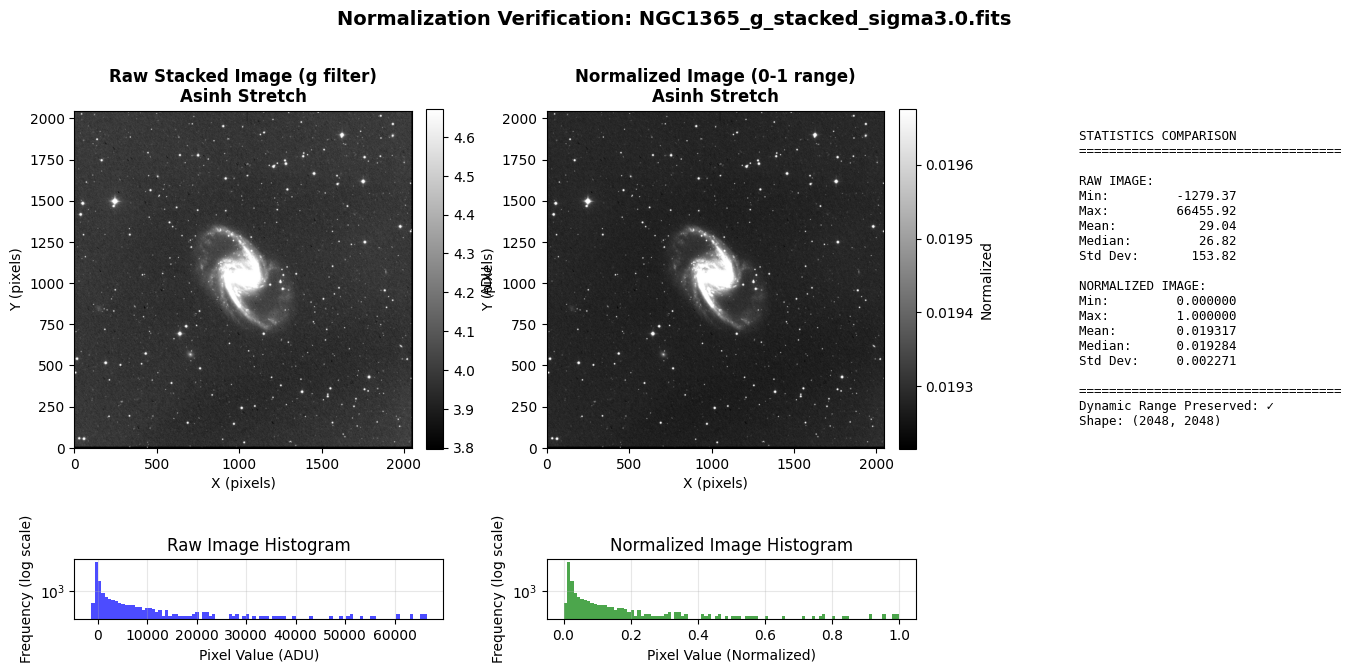


Processing: NGC1365_i_stacked_sigma3.0.fits
Saved comparison to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons/comparison_NGC1365_i_stacked_sigma3.0.png


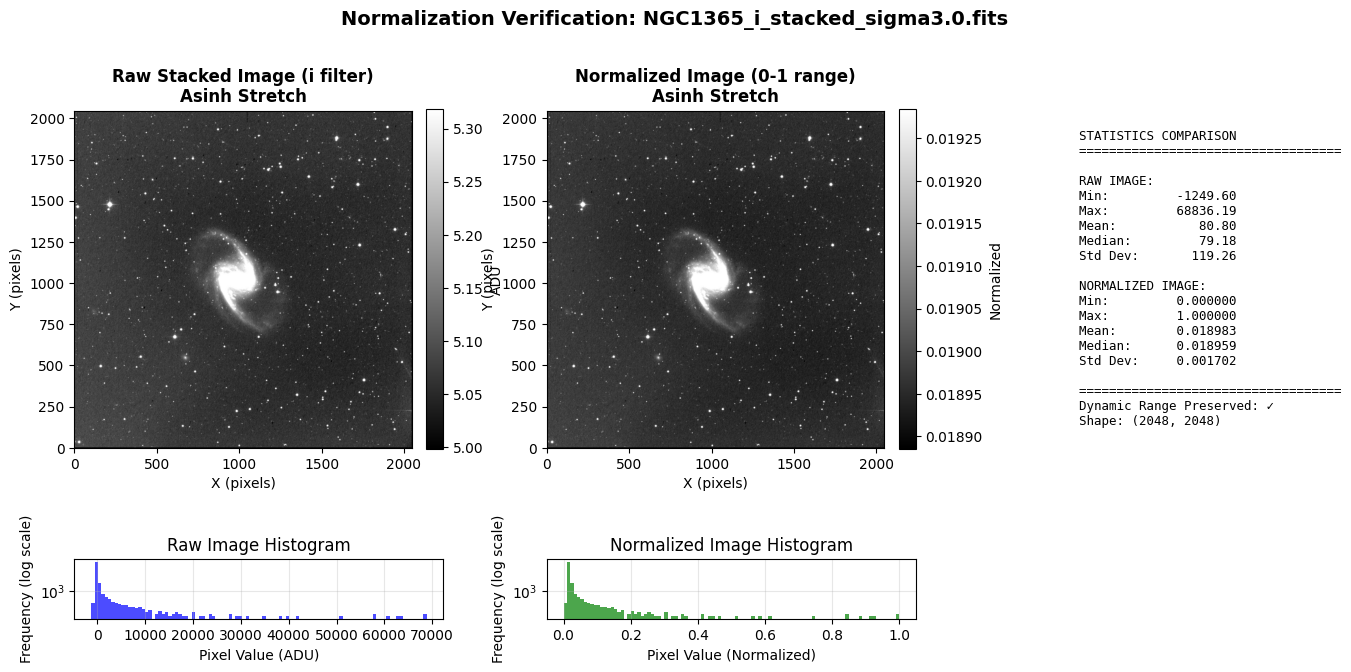


Processing: NGC1365_r_stacked_sigma3.0.fits
Saved comparison to: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons/comparison_NGC1365_r_stacked_sigma3.0.png


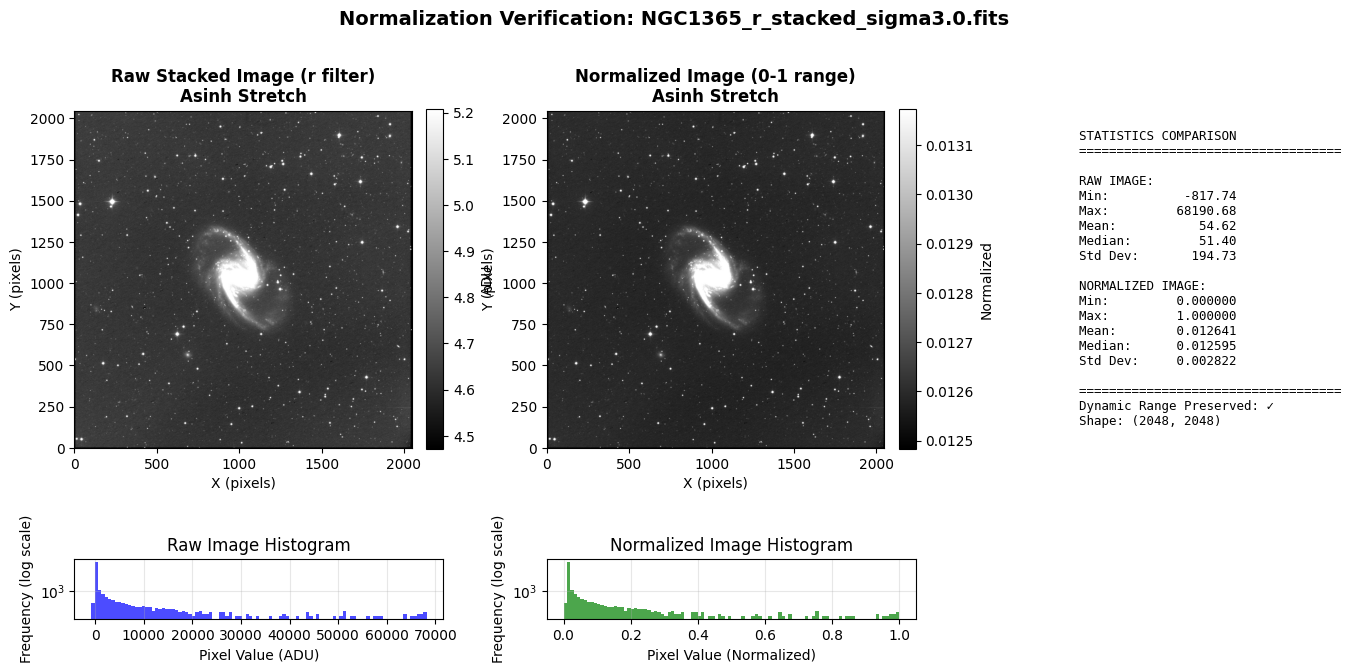


All comparison visualizations complete!
Images saved in: /home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons


In [2]:
import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsinhStretch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os
import glob

def visualize_normalization_comparison(raw_path, normalized_path, output_path=None, 
                                       stretch='asinh', vmin_percentile=1, vmax_percentile=99):
    """
    Create side-by-side comparison of raw and normalized images.
    
    Parameters:
    -----------
    raw_path : str
        Path to raw/stacked FITS file
    normalized_path : str
        Path to normalized FITS file
    output_path : str
        Path to save comparison image (if None, displays only)
    stretch : str
        Visualization stretch: 'linear', 'log', 'asinh', 'zscale'
    vmin_percentile, vmax_percentile : float
        Percentiles for display scaling
    """
    
    # Read FITS files
    with fits.open(raw_path) as hdul:
        raw_data = hdul[0].data
        raw_header = hdul[0].header
    
    with fits.open(normalized_path) as hdul:
        norm_data = hdul[0].data
        norm_header = hdul[0].header
    
    # Get filter name from filename
    filter_name = os.path.basename(raw_path).split('_')[1] if '_' in os.path.basename(raw_path) else 'Unknown'
    
    # Create figure
    fig = plt.figure(figsize=(16, 7))
    gs = GridSpec(2, 3, figure=fig, hspace=0.35, wspace=0.3, 
                  height_ratios=[1, 0.15], width_ratios=[1, 1, 0.8])
    
    # Calculate statistics
    raw_stats = {
        'min': np.nanmin(raw_data),
        'max': np.nanmax(raw_data),
        'mean': np.nanmean(raw_data),
        'median': np.nanmedian(raw_data),
        'std': np.nanstd(raw_data)
    }
    
    norm_stats = {
        'min': np.min(norm_data),
        'max': np.max(norm_data),
        'mean': np.mean(norm_data),
        'median': np.median(norm_data),
        'std': np.std(norm_data)
    }
    
    # Apply visualization stretch
    if stretch == 'zscale':
        interval = ZScaleInterval()
        raw_vmin, raw_vmax = interval.get_limits(raw_data)
        norm_vmin, norm_vmax = interval.get_limits(norm_data)
    else:
        raw_vmin = np.nanpercentile(raw_data, vmin_percentile)
        raw_vmax = np.nanpercentile(raw_data, vmax_percentile)
        norm_vmin = np.percentile(norm_data, vmin_percentile)
        norm_vmax = np.percentile(norm_data, vmax_percentile)
    
    # Apply stretch transformation
    if stretch == 'log':
        # Shift data to positive for log
        raw_display = np.log10(raw_data - raw_data.min() + 1)
        norm_display = np.log10(norm_data - norm_data.min() + 1)
        stretch_label = 'Log'
    elif stretch == 'asinh':
        raw_display = np.arcsinh(raw_data)
        norm_display = np.arcsinh(norm_data)
        stretch_label = 'Asinh'
    else:
        raw_display = raw_data
        norm_display = norm_data
        stretch_label = 'Linear'
    
    # Plot raw image
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(raw_display, cmap='gray', origin='lower', 
                     vmin=np.percentile(raw_display, vmin_percentile),
                     vmax=np.percentile(raw_display, vmax_percentile))
    ax1.set_title(f'Raw Stacked Image ({filter_name} filter)\n{stretch_label} Stretch', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='ADU')
    
    # Plot normalized image
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(norm_display, cmap='gray', origin='lower',
                     vmin=np.percentile(norm_display, vmin_percentile),
                     vmax=np.percentile(norm_display, vmax_percentile))
    ax2.set_title(f'Normalized Image (0-1 range)\n{stretch_label} Stretch', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Normalized')
    
    # Statistics table
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.axis('off')
    
    stats_text = f"""
    STATISTICS COMPARISON
    {'='*35}
    
    RAW IMAGE:
    Min:     {raw_stats['min']:>12.2f}
    Max:     {raw_stats['max']:>12.2f}
    Mean:    {raw_stats['mean']:>12.2f}
    Median:  {raw_stats['median']:>12.2f}
    Std Dev: {raw_stats['std']:>12.2f}
    
    NORMALIZED IMAGE:
    Min:     {norm_stats['min']:>12.6f}
    Max:     {norm_stats['max']:>12.6f}
    Mean:    {norm_stats['mean']:>12.6f}
    Median:  {norm_stats['median']:>12.6f}
    Std Dev: {norm_stats['std']:>12.6f}
    
    {'='*35}
    Dynamic Range Preserved: ✓
    Shape: {raw_data.shape}
    """
    
    ax3.text(0.1, 0.5, stats_text, fontsize=9, family='monospace',
             verticalalignment='center', transform=ax3.transAxes)
    
    # Histograms
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.hist(raw_data.flatten(), bins=100, color='blue', alpha=0.7, log=True)
    ax4.set_xlabel('Pixel Value (ADU)')
    ax4.set_ylabel('Frequency (log scale)')
    ax4.set_title('Raw Image Histogram')
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.hist(norm_data.flatten(), bins=100, color='green', alpha=0.7, log=True)
    ax5.set_xlabel('Pixel Value (Normalized)')
    ax5.set_ylabel('Frequency (log scale)')
    ax5.set_title('Normalized Image Histogram')
    ax5.grid(True, alpha=0.3)
    
    # Overall title
    fig.suptitle(f'Normalization Verification: {os.path.basename(raw_path)}', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    # Save or show
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison to: {output_path}")
    
    plt.tight_layout()
    plt.show()


def create_all_comparisons(raw_dir, norm_dir, output_dir=None, stretch='asinh'):
    """
    Create comparison visualizations for all filter images.
    
    Parameters:
    -----------
    raw_dir : str
        Directory containing raw stacked images
    norm_dir : str
        Directory containing normalized images
    output_dir : str
        Directory to save comparison plots (if None, displays only)
    stretch : str
        Visualization stretch method
    """
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Find all raw FITS files
    raw_files = sorted(glob.glob(os.path.join(raw_dir, '*.fits')))
    
    print(f"Creating comparison visualizations for {len(raw_files)} images...")
    print(f"Using {stretch} stretch for display\n")
    
    for raw_file in raw_files:
        base_name = os.path.basename(raw_file)
        norm_file = os.path.join(norm_dir, f"normalized_{base_name}")
        
        if not os.path.exists(norm_file):
            print(f"Warning: Normalized file not found for {base_name}")
            continue
        
        output_path = None
        if output_dir:
            output_path = os.path.join(output_dir, f"comparison_{base_name.replace('.fits', '.png')}")
        
        print(f"Processing: {base_name}")
        visualize_normalization_comparison(raw_file, norm_file, output_path, stretch)
        print()


# Main execution
if __name__ == "__main__":
    
    # Define paths
    raw_directory = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED"
    norm_directory = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/normalized"
    output_directory = "/home/devika/PhD/S2/Obs_Astronomy/Image_Processing/Ckoirama_2025-12-19/Image_reduction_workspace/STACKED/comparisons"
    
    # Create comparison visualizations
    # stretch options: 'linear', 'log', 'asinh', 'zscale'
    create_all_comparisons(raw_directory, norm_directory, output_directory, stretch='asinh')
    
    print("All comparison visualizations complete!")
    print(f"Images saved in: {output_directory}")